# Introduction

Following up on $d$-separation, my colleagues and I chatted about how to find the confounding set of variables in a causal graph. This is another graph search problem. Let's see how this can be applied.

In [2]:
from custom import rule1, rule2, rule3, path_nodes
import networkx as nx
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/causality/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/ericmjl/anaconda/envs/causality/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


From Judea Pearl's book, there is a diagram in chapter 4, `Figure 4.7`. Let's reproduce it here.

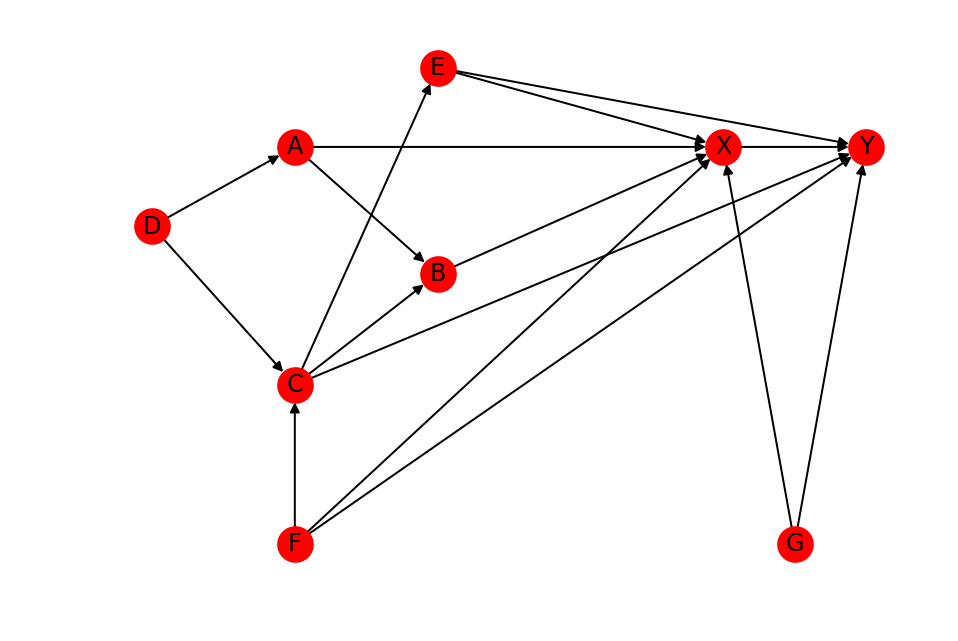

In [3]:
G = nx.DiGraph()
edges = [
    ('D', 'A'), ('D', 'C'), ('F', 'C'),
    ('A', 'B'), ('C', 'B'), ('C', 'Y'),
    ('F', 'X'), ('F', 'Y'), ('C', 'E'),
    ('A', 'X'), ('E', 'X'), ('E', 'Y'),
    ('B', 'X'), ('X', 'Y'), ('G', 'X'), 
    ('G', 'Y')
]
G.add_edges_from(edges)
pos = {
    'D': (0, 0),
    'A': (1, 0.5),
    'C': (1, -1),
    'F': (1, -2),
    'B': (2, -0.3),
    'E': (2, 1),
    'X': (4, 0.5),
    'G': (4.5, -2),
    'Y': (5, 0.5)
}
nx.draw(G, pos=pos, with_labels=True)

To reveal the answer, the minimum confounding set is $\{A, B, E, F, G\}$.

What we would like to know is what is the set of confounders that we need to control for in order to correctly estimate the effect of $X$ on $Y$.

To do this, we use the following logic:

1. Find all undirected paths between $X$ and $Y$.
1. Traverse each node in the undirected paths. 
1. Check to see if, in the directed graph, the node blocks the path between $X$ and $Y$ if it were in the conditioning set.
    1. If yes, then it should be included as a confounder. Break out and continue on to next path.
    1. If no, it should not be included as a confounder.

In [5]:
Gpath = G.to_undirected()

confounders = set()
n1 = 'X'
n2 = 'Y'
for i, path in enumerate(nx.all_simple_paths(Gpath, n1, n2)):
    for n in path:
        if n is not n1 and n is not n2:
            pass1 = rule1(n, [n], G, path)
            pass2 = rule2(n, [n], G, path)
            pass3 = rule3(n, [], G, path)
            if pass1 or pass2 or pass3:
                confounders.add(n)
                # We break, because as soon as we find a good
                # blocking node, there is no need to continue
                # looking at other nodes.
                break
confounders

{'A', 'B', 'E', 'F', 'G'}

We did it!